## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [4]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


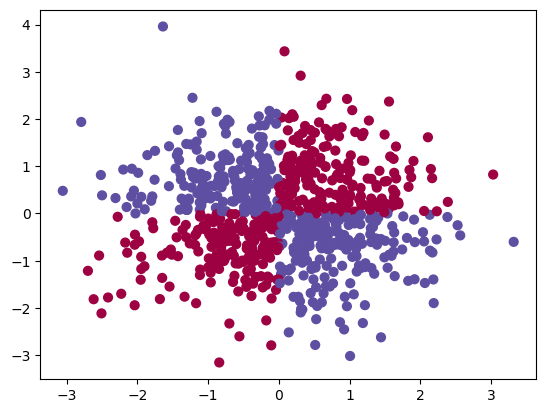

In [5]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

Two Layer Perceptron

In [ ]:
class TwoLayerPerceptron:
    def __init__(self, input_size, hidden_size, output_size, learning_rate):
        # initializing weights randomly & biases to zero #
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01
        self.biases1 = np.zeros((1, hidden_size))
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01
        self.biases2 = np.zeros((1, output_size))
        self.learning_rate = learning_rate
    
    # Activation Functions #
    def ReLU(self, x):
        return np.maximum(0, x)

    def ReLU_deriv(self, x):
        return (x > 0).astype(float)

    def sigmoid(self, x):
        return 1/ (1 + np.exp(-x))
    
    # Loss Function #
    def cross_entropy_l(self, y_true, y_pred):
        epsilon = 1e-12
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    # Forward Pass # 
    def forward(self, X):
        # Hidden Layer #
        self.z1 = X.dot(self.weights1) + self.biases1
        self.a1 = self.ReLU(self.z1)
        # Output Layer #
        self.z2 = self.a1.dot(self.weights2) + self.biases2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    # Backward pass #
    def backward(self, X, y):
        m = X.shape[0]
        dz2 = self.a2 - y # gradient with respect to output z2
        dw2 = self.a1.T.dot(dz2) / m
        db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = dz2.dot(self.weights2.T) * self.ReLU_deriv(self.z1) # backpropagate the error to hidden layer
        dw1 = X.T.dot(dz1) / m
        db1 = np.sum(dz1, axis=0, keepdims=True) / m

        # Update weights and biases using gradients & LR
        self.weights1 -= self.learning_rate * dw1
        self.biases1 -= self.learning_rate * db1
        self.weights2 -= self.learning_rate * dw2
        self.biases2 -= self.learning_rate * db2
    
    # Train the model # 
    def fit(self, X_train, y_train, epochs, batch_size):
        for epoch in range(epochs):
            # shuffle training data for epoch
            indices = np.arange(X_train.shape[0])
            np.random.shuffle(indices)
            X_train = X_train[indices]
            y_train = y_train[indices]

            # divide data into mini-batches
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_train[i:i + batch_size]
                y_batch = y_train[i:i + batch_size]
                y_batch = y_batch.reshape(-1, 1)

                # Is done for each batch #
                self.forward(X_batch)
                self.backward(X_batch, y_batch)
            
            # same for this #
            predictions = self.forward(X_train)
            loss = self.cross_entropy_l(y_train, predictions)
    
    # Predict class #
    def predict(self, X):
        predictions = self.forward(X)
        return (predictions > 0.5).astype(int)

Cross Validation

In [32]:
from sklearn.metrics import accuracy_score

def CV(X, y, hidden_size, epochs, batch_size, learning_rate, folds = 5):
    fold_size = len(X) // folds
    accuracy_scores = []
    # Split data #
    for fold in range(folds):
        X_train = np.concatenate([X[:fold * fold_size], X[(fold + 1) * fold_size:]], axis = 0)
        y_train = np.concatenate([y[:fold * fold_size], y[(fold + 1) * fold_size:]], axis = 0)
        X_val = X[fold * fold_size:(fold + 1) * fold_size]
        y_val = y[fold * fold_size:(fold + 1) * fold_size]

        # Train model #
        model = TwoLayerPerceptron(input_size = X.shape[1], hidden_size = hidden_size, output_size = 1, learning_rate = learning_rate)
        model.fit(X_train, y_train, epochs, batch_size)
        
        # Evaluate accuracy #
        predictions = model.predict(X_val)
        accuracy = accuracy_score(y_val, predictions)
        accuracy_scores.append(accuracy)
        print(f"Fold {fold + 1}, Accuracy: {accuracy:.4f}")

In [8]:
# hyperparameters
hidden_size = 10
epochs = 500
batch_size = 16
learning_rate = 0.01
folds = 5

CV(X_train, y_train, hidden_size, epochs, batch_size, learning_rate, folds)

Fold 1, Accuracy: 0.9625
Fold 2, Accuracy: 1.0000
Fold 3, Accuracy: 0.9938
Fold 4, Accuracy: 0.9750
Fold 5, Accuracy: 0.9437


Train the model

In [13]:
FM = TwoLayerPerceptron(input_size = 2, hidden_size = 10, output_size = 1, learning_rate = 0.01)
FM_fit = FM.fit(X_train, y_train, 500, 16)
y_test_pred = FM.predict(X_test)

Classification Report

In [14]:
from sklearn.metrics import classification_report

test_report = classification_report(y_test, y_test_pred, target_names = ["Class 0", "Class 1"])
print("\nClassification Report - Test Set:")
print(test_report)

print("\nClassification Report - Test Set:")
print(test_report)


Classification Report - Test Set:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        97
     Class 1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Classification Report - Test Set:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00        97
     Class 1       1.00      1.00      1.00       103

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



Summary:

The model achieved perfect classification performance on the test set, with 100% accuracy, precision, recall, and F1-score for both classes. All 200 samples were correctly classified, indicating that the model effectively learned the decision boundary. This result demonstrates flawless performance with no false positives or false negatives, suggesting excellent generalization for the given dataset.

Extra: Visualizing decision boundary

<Figure size 800x600 with 0 Axes>

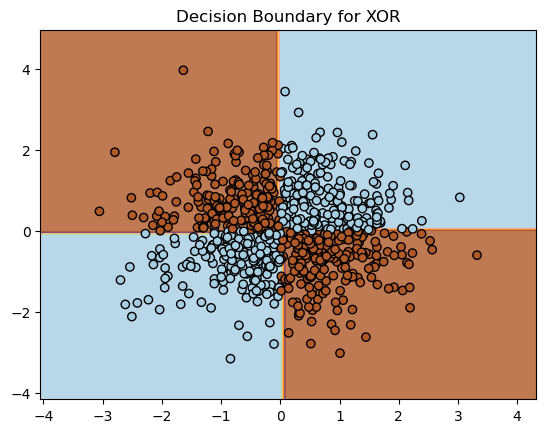

In [31]:
from sklearn.utils.validation import check_is_fitted
from sklearn.inspection import DecisionBoundaryDisplay

class SklearnWrapper():
    def __init__(self, trained_model):
        self.model = trained_model
        self.classes_ = None

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.is_fitted_ = True
        return self

    def predict(self, X):
        return self.model.predict(X).flatten() 

    def _check_is_fitted(self):
        check_is_fitted(self, "is_fitted_")

wrapped_model = SklearnWrapper(FM)
wrapped_model.fit(X_train, y_train)

plt.figure(figsize=(8, 6))
DecisionBoundaryDisplay.from_estimator(
    wrapped_model, X_train, response_method="predict", cmap=plt.cm.Paired, alpha=0.8
)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolor="k", cmap=plt.cm.Paired)
plt.title("Decision Boundary for XOR")
plt.show()